In this notebook, we load the preprocessed dataset as created in 'Project_preprocessing' and build a XGBoost Regressor model. The preprocessed dataset is split into train and test sets. <br>
1. Naive Baseline - Predictions on the test set are performed using 'Naive Baseline' model (mean strategy). The baseline Root mean square error (RMSE) is thus established.
2. Default model - The default XGBoost model is evaluated with 5 fold cross validation on train set. The model is then fit on the train data and predictions are performed on test data. RMSE using default model on test data is reported.
3. Tuned model - Lastly, we optimize the parameters of the model using 5 cross validation. An extensive parameter search is performed using several grid searches. 'neg_root_mean_squared_error' is used as scoring function during grid search. The 'best estimator' model obtained after grid searches with 5 fold cross validation is finally used to perform predictions on the test set. RMSE obtained using tuned model on test set is compared with that of Default model and Naive Baseline model. 

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [121]:
dataset = pd.read_csv('melbourne-airbnb.csv')
X = dataset.drop('price',axis=1)
y = dataset['price']

In [122]:
#split into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

## Naive Baseline

In [123]:
#create naive baseline
from sklearn.metrics import mean_squared_error, r2_score
mean_price = np.mean(y)
y_test_naive = np.repeat(mean_price, len(y_test))
naive_rmse = mean_squared_error(y_test, y_test_naive)
naive_rmse = np.sqrt(naive_rmse)
naive_r2 = r2_score(y_test,y_test_naive)
print('Naive Baseline RMSE on test set: ' + str(round(naive_rmse,2)))
print('Naive Baseline R2 on test set: ' + str(round(naive_r2,2)))

Naive Baseline RMSE on test set: 75.75
Naive Baseline R2 on test set: -0.0


## XGBoost - Default parameters
Evaluate default model with 5 fold cross validation on train set. Fit model on entire train set, perform predictions on test set and calculate RMSE.

In [124]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

#build xgboost model
model = XGBRegressor(seed=123)

# evaluate default model with 5 fold cross validation on train set
scores = cross_val_score(model,X_train,y_train, cv=5, scoring='neg_root_mean_squared_error')
mean_score = abs(np.mean(scores))

#fit model on entire train set and predict on test set
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# evaluate predictions made on test set
xg_def_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('XGBoost (default parameters) mean cross validated RMSE on train set: ' + str(round(mean_score,2)))
print()
print("XGBoost (default parameters) RMSE on test set: " + str(round(xg_def_rmse,2))) 


XGBoost (default parameters) mean cross validated RMSE on train set: 50.28

XGBoost (default parameters) RMSE on test set: 49.53


## XGBoost Hyperparameter optimization
Perform hyperparameter tuning using grid search with 5 fold cross validation on train set. Evaluate tuned model on test set and calculate RMSE.  

In [125]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

steps = [('XGB',XGBRegressor() )]
pipeline = Pipeline(steps)

#define hyperparameters to tune
parameters = {'XGB__colsample_bytree': [0.8,0.9,1.0],'XGB__subsample': [0.9,1.0],
                'XGB__max_depth': [9,10,11], 'XGB__eta':[0.05,0.1], 'XGB__min_child_weight':[2,4,6] }

#perform grid search using cross validation
grid1_xg = GridSearchCV(pipeline, param_grid=parameters, cv=5,scoring='neg_root_mean_squared_error')
grid1_xg.fit(X_train, y_train)
print('Best Parameters with grid1:') 
print(grid1_xg.best_params_)
print()
grid1_rmse = abs(grid1_xg.best_score_)
best_std = grid1_xg.cv_results_['std_test_score'][grid1_xg.best_index_]
print('Mean cross validated RMSE with best estimator grid1: '+ str(round(grid1_rmse,2)) + ', Standard deviation: ' + str(round(best_std,2)))

Best Parameters with grid1:
{'XGB__colsample_bytree': 0.8, 'XGB__eta': 0.1, 'XGB__max_depth': 9, 'XGB__min_child_weight': 4, 'XGB__subsample': 0.9}

Mean cross validated RMSE with best estimator grid1: 49.05, Standard deviation: 1.14


In [126]:
#further tuning with more parameters
steps = [('XGB',XGBRegressor(seed=123,colsample_bytree= 0.8, eta= 0.1) )]
pipeline = Pipeline(steps)

#define hyperparameters to tune
parameters = {'XGB__max_depth': [7,8,9], 'XGB__alpha':[0,2], 'XGB__subsample': [0.8,0.9]}

#perform grid search using cross validation
grid2_xg = GridSearchCV(pipeline, param_grid=parameters, cv=5, scoring='neg_root_mean_squared_error')
grid2_xg.fit(X_train, y_train)

print('Best Parameters with grid2:') 
print(grid2_xg.best_params_)
print()
grid2_rmse = abs(grid2_xg.best_score_)
best_std = grid2_xg.cv_results_['std_test_score'][grid2_xg.best_index_]
print('Mean cross validated RMSE with best estimator grid2: '+ str(round(grid2_rmse,2)) + ', Standard deviation: ' + str(round(best_std,2)))

Best Parameters with grid2:
{'XGB__alpha': 0, 'XGB__max_depth': 8, 'XGB__subsample': 0.8}

Mean cross validated RMSE with best estimator grid2: 49.07, Standard deviation: 1.38


No further improvement in performance was seen with more tuning of hyperparameters. The estimator obtained by grid1 was chosen as the best estimator and used for evaluation on test set. 

In [127]:
#predict using model with best estimator from grid search
y_pred_tuned = grid1_xg.predict(X_test)
xg_tuned_r2 = r2_score(y_test,y_pred_tuned)
xg_tuned_rmse = mean_squared_error(y_test, y_pred_tuned)
xg_tuned_rmse = np.sqrt(xg_tuned_rmse)
print('R2 score using tuned XGBoost on test set: ' + str(round(xg_tuned_r2,1)))
print()
print('RMSE using tuned XGBoost on test set: ' + str(round(xg_tuned_rmse,2)))

R2 score using tuned XGBoost on test set: 0.6

RMSE using tuned XGBoost on test set: 48.11


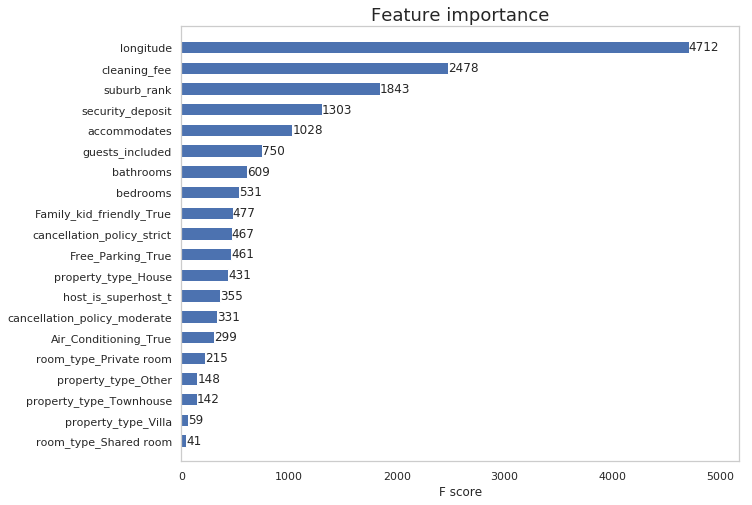

In [128]:
#plot feature importances of best estimator
from xgboost import plot_importance
reg = grid1_xg.best_estimator_['XGB']
xg_model = reg.fit(X_train,y_train)
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(xg_model,height=0.6,grid=False,ylabel='', ax=ax)
plt.title("Feature importance", fontsize=18)
plt.xlabel("F score", fontsize=12);

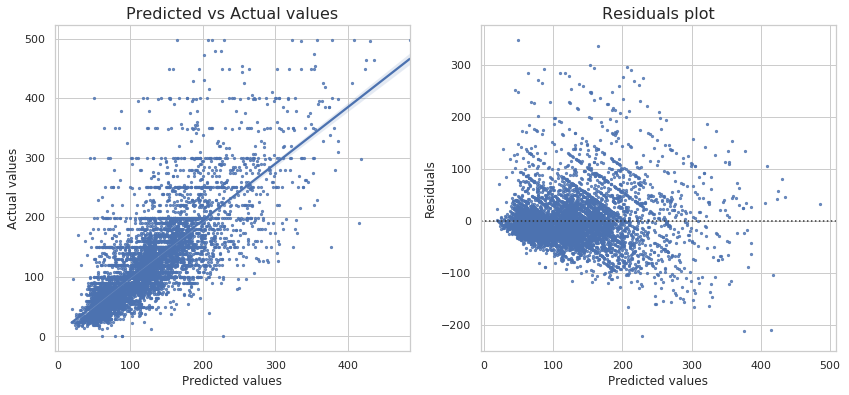

In [129]:
#plot predicted vs actual values and residuals plot

residuals = y_test-y_pred_tuned

sns.set(style="whitegrid")
fig,(ax1,ax2) = plt.subplots(1,2, figsize= (14,6))

sns.regplot(x = y_pred_tuned, y=y_test,scatter_kws={'s':5}, ax=ax1)
ax1.set_xlabel('Predicted values',fontsize=12)
ax1.set_ylabel('Actual values',fontsize=12)
ax1.set_title('Predicted vs Actual values', fontsize = 16)
sns.residplot(x=y_pred_tuned, y=residuals,scatter_kws={'s':5}, ax=ax2)
ax2.set_xlabel('Predicted values',fontsize=12)
ax2.set_ylabel('Residuals',fontsize=12)
ax2.set_title('Residuals plot', fontsize=16);

The predicted values using tuned model follow the overall trend of actual values. Predictions are more accurate in the range of ~ $50-200 where majority of the data points lie. Beyond this range, the model performance is poor and mostly under or overestimating the price.

In [130]:
#final summary
print('Summarizing: ')
print()
print('Naive Baseline RMSE on test set: ' + str(round(naive_rmse,2)))
print()
print("XGBoost (default parameters) RMSE on test set: " + str(round(xg_def_rmse,2))) 
print()
print('XGBoost (tuned parameters) RMSE on test set: ' + str(round(xg_tuned_rmse,2)))


Summarizing: 

Naive Baseline RMSE on test set: 75.75

XGBoost (default parameters) RMSE on test set: 49.53

XGBoost (tuned parameters) RMSE on test set: 48.11


## Saving Model
The optimized XGBoost regressor model is our best performing model and therefore we will save it for future use.

In [131]:
#save the best performing model in working directory
import pickle
# specify filename
filename= "Pickle_XGBoost_model.pkl"
with open (filename,'wb') as file:
    pickle.dump(xg_model,file)

In [132]:
#use saved model to perform predictions
with open (filename,'rb') as file:
    Pickle_XGBoost_model = pickle.load(file)

#view saved model
print('Best performing model: ')
print()
print(Pickle_XGBoost_model)
print()
pickle_pred = Pickle_XGBoost_model.predict(X_test)
xg_model_rmse = np.sqrt(mean_squared_error(y_test, pickle_pred))
print('XGBoost (saved model) RMSE on test set: ' + str(round(xg_model_rmse,2)))

Best performing model: 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=9,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

XGBoost (saved model) RMSE on test set: 48.11
